# Project: ICD-AIS conversion using Deep Learning

This script checks the accuracy of AIS predictions in the training data.

## Setup

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import random
import math

## Parameters


In [3]:
ais_pred_onmt_file = "../Results/train_ais_pred_early_stop-10000.csv"
ais_map_file = "../Results/test_ais_pred_aaam_map.csv"
ais_obs_file = "../Data/train_ais_pre_I9_A05.csv"
icd_obs_file ="../Data/train_icd_pre_I9_A05-10000.csv"
ais_codes_file = "../Data/AIS08_codes.csv"

## Load data and merge

In [4]:
# load predictions
ais_pred = pd.read_csv(ais_pred_onmt_file, header=None, skip_blank_lines=False,names=["AIS05CODE"])

In [5]:
# load mapped values
ais_map = pd.read_csv(ais_map_file, header=None, skip_blank_lines=False, names=["AIS05CODE"])

In [6]:
# load observations
ais_obs = pd.read_csv(ais_obs_file, header=None, names=["AIS05CODE"])

In [7]:
# load predictions
test_res = pd.read_csv(icd_obs_file, header=None, names=["ICD9CODE"])

In [8]:
# merge data
test_res['AIS_obs'] = ais_obs.AIS05CODE
test_res['AIS_pred'] = ais_pred.AIS05CODE
test_res['AIS_map'] = ais_map.AIS05CODE

In [9]:
# load AIS codes
ais_codes = pd.read_csv(ais_codes_file, header=0, encoding='iso-8859-1')

# get predot code
ais_codes['predot'] = ais_codes.code.apply(lambda x: math.floor(x))

# make dictionary of codes
ais_dot = pd.Series(ais_codes.code.values, index=ais_codes.predot).to_dict()
ais_dot[0] = 0.0
ais_dot[-1] = -1.0

## Process AIS codes 
- Convert to list 
- Remove missing and unknown predicted values
- Convert to numbers
- Add post-dot to AIS

In [10]:
# convert string to list
test_res['AIS_obs'] = test_res.AIS_obs.str.split(" ")
test_res['AIS_pred'] = test_res.AIS_pred.str.split(" ")

In [11]:
# replace predicted NaN (no prediction for patient) with 0 
test_res['AIS_pred'] = [ ["0"] if x is np.NaN else x for x in test_res['AIS_pred']]

# replace <unk> (unknown code encountered) with -1
test_res['AIS_pred'] = test_res.apply(lambda x: ["-1" if val=="<unk>" else val for val in x['AIS_pred']], axis=1)

In [12]:
# convert to numbers
test_res['AIS_obs'] = test_res.apply(lambda x: [int(val) for val in x['AIS_obs']], axis=1)
test_res['AIS_pred'] = test_res.apply(lambda x: [int(val) for val in x['AIS_pred']], axis=1)

In [13]:
# convert map string to number
test_res['AIS_map'] = test_res.AIS_map.str.replace('[','').str.replace(']','')
test_res['AIS_map'] = test_res.apply(lambda x: [np.float64(val) for val in x['AIS_map'].split(",")], axis=1)

In [14]:
# add post-dot code
test_res['AIS_obs'] = test_res.apply(lambda x: [ais_dot[val] for val in x['AIS_obs']], axis=1)
test_res['AIS_pred'] = test_res.apply(lambda x: [ais_dot[val] for val in x['AIS_pred']], axis=1)

In [15]:
test_res.head(15)

,ICD9CODE,AIS_obs,AIS_pred,AIS_map
0,A61 E813.2 P38.93 P79.06 P79.36 P86.22 P86.59 ...,"[110402.1, 450203.3, 710402.1, 752521.2, 84009...","[110402.1, 450203.3, 710402.1, 752400.2, 84060...",[110000.1]
1,A30 E960.0 P76.74 P93.55 D802.29 D802.8 D850.1...,"[161000.1, 161003.2, 210402.1, 210600.1, 25020...","[161000.1, 161003.2, 210402.1, 210600.1, 25040...","[420000.3, 620000.2, 630000.2]"
2,A82 E885.9 P81.52 D820.8,[853161.3],[853161.3],[840000.3]
3,A60 E884.2 P38.93 P87.03 P88.38 D805.2 D807.00...,"[110600.1, 450200.1, 650432.2]","[110600.1, 450200.1, 650416.2]","[630000.2, 840000.2, 840000.2]"
4,A61 E885.9 P00.39 P38.93 P79.32 D813.01 D923.9,"[710402.1, 752113.2]","[710402.1, 752113.2]",[560000.1]
5,A62 E885.9 P79.36 D823.01 D823.80 D924.5,"[810402.1, 854000.2, 854471.2]","[810402.1, 854000.2, 854471.2]",[110000.3]
6,A49 E821.0 P87.03 P87.41 P88.01 P88.38 P88.79 ...,[161002.2],[161002.2],[740000.2]
7,A49 E960.0 P87.03 P88.38 D802.0 D802.24 D802.4...,"[140694.2, 250608.1, 251002.2, 251800.1]","[140693.2, 250608.1, 250800.2, 251000.1]",[840000.3]
8,A84 E880.9 P-1 D807.09,[450200.1],[450210.2],"[110000.3, 160000.1]"
9,A85 E885.9 P81.52 D820.8,[853161.3],[853161.3],"[110000.2, 160000.1, 740000.2]"


## Function to match AIS codes from two list
This function will return the best estimate for matching two lists of AIS codes.

In [17]:
def match_ais(ais1, ais2):
    '''
    This function matches AIS codes from two lists with proximation.  The overarching concept
    is to match codes based on 1) exact matches, 2) same body region-same severity, 
    3) same body region-different severity, 4) different body region-same severity, 
    5) remaining codes are paired in decreasing severity, 6) unmatched codes are then added.
    
    Parameters:
        ais1 - list of AIS codes
        ais2 - list of AIS codes
    Returns:
        Pandas dataframe with matched codes
    '''
    
    # df for matches
    matches = pd.DataFrame(columns={'codes1','code2'})
    
    # df for data
    df1 = pd.DataFrame({'ais_code':ais1, 'curr_prec':ais1}).sort_values('ais_code')
    df2 = pd.DataFrame({'ais_code':ais2, 'curr_prec':ais2}).sort_values('ais_code')

    # determine body region
    df1['region'] = np.floor(df1.ais_code/100000)
    df2['region'] = np.floor(df2.ais_code/100000)
    
    # determine severity
    df1['severity'] = np.round(df1.curr_prec%1 * 10)
    df2['severity'] = np.round(df2.curr_prec%1 * 10)

    # move severity to the 2nd MSD
    df1['curr_prec'] = np.floor(df1.region * 1000000 + df1.severity * 100000 + df1.ais_code%100000)
    df2['curr_prec'] = np.floor(df2.region * 1000000 + df2.severity * 100000 + df2.ais_code%100000)    
    
    # matching steps #1-3, loop through all digits
    for digit in range(0,7):

        # loop through ais1 codes
        for i in range(0,len(df1)):

            # loop through ais2 codes
            for j in range(0,len(df2)):

                # check for match
                if df1.curr_prec[i] == df2.curr_prec[j]:

                    # match found, add to match list
                    matches = matches.append({'code1':df1.ais_code[i], 'code2':df2.ais_code[j]}, ignore_index=True)

                    # remove rows with matched codes from dfs
                    df1 = df1.drop(index=i, axis=1)
                    df2 = df2.drop(index=j, axis=1).reset_index(drop=True)

                    # stop searching for code
                    break

        # decrease precision, on first loop this removes severity
        df1['curr_prec'] = np.floor(df1.curr_prec/10)
        df2['curr_prec'] = np.floor(df2.curr_prec/10)

        # reset index for list1
        df1 = df1.reset_index(drop=True) 

    # matching step #4 - find same severity in different body regions    
        
    # assign severity to current precision
    df1['curr_prec'] = df1.severity
    df2['curr_prec'] = df2.severity
    
    # sort based on codes
    df1 = df1.sort_values('ais_code').reset_index(drop=True)
    df2 = df2.sort_values('ais_code').reset_index(drop=True)
    
    #loop through all unmatched codes in list 1
    for i in range(0,len(df1)):
        
        # loop through unmatched codes in list 2
        for j in range(0,len(df2)):
                
            # check for match
            if df1.curr_prec[i] == df2.curr_prec[j]:

                # match found, add to match list
                matches = matches.append({'code1':df1.ais_code[i], 'code2':df2.ais_code[j]}, ignore_index=True)

                # remove rows with matched codes from dfs
                df1 = df1.drop(index=i, axis=1)
                df2 = df2.drop(index=j, axis=1).reset_index(drop=True)

                # stop searching for code
                break
                
    # matching step #5-6, sequentially assign unmatched codes from based on decreasing AIS severity

    # arrange in decreasing severity
    df1 = df1.sort_values('curr_prec', ascending=False).reset_index(drop=True)
    df2 = df2.sort_values('curr_prec', ascending=False).reset_index(drop=True)
  
    #loop through all unmatched codes in list 1
    for i in range(0,len(df1)):

        # check if list 2 still has any numbers
        if len(df2) > 0:

            # add to match list
            matches = matches.append({'code1':df1.ais_code[i], 'code2':df2.ais_code[0]}, ignore_index=True)

            # remove rows with matched codes from df
            df2 = df2.drop(index=0, axis=1).reset_index(drop=True)

        # else no more codes in list 2
        else:

            # add to match list
            matches = matches.append({'code1':df1.ais_code[i], 'code2':None}, ignore_index=True)

        # remove code from list 1
        df1 = df1.drop(index=i, axis=1)

    # assign unmatched to any remaining codes list 2
    for j in range(0,len(df2)):

        # add to match list
        matches = matches.append({'code1':None, 'code2':df2.ais_code[j]}, ignore_index=True)
        
    # remove values that are undefined
    matches['code1'] = matches.code1.apply(lambda x: None if x<=0 else x)
    matches['code2'] = matches.code2.apply(lambda x: None if x<=0 else x)

    # arrange by decrease AIS severity
    matches['severity1'] = matches.code1%1
    matches = matches.sort_values('code1').sort_values('severity1',ascending=False)[['code1','code2']].reset_index(drop=True)

    return matches

In [18]:
i = 17
print("Codes1: ", test_res.AIS_obs[i])
print("Codes2: ", test_res.AIS_pred[i])

match_ais(test_res.AIS_obs[i],test_res.AIS_pred[i])

Codes1:  [751101.2, 752801.2, 772020.1]
Codes2:  [751101.2, 752801.2, 753201.2, 772020.1]


,code1,code2
0,751101.2,751101.2
1,752801.2,752801.2
2,772020.1,772020.1
3,NaN,753201.2


In [19]:
i = 11
print("Codes1: ", test_res.AIS_obs[i])
print("Codes2: ", test_res.AIS_map[i])

match_ais(test_res.AIS_obs[i],test_res.AIS_map[i])

Codes1:  [650600.2, 650630.2, 752400.2, 752800.2]
Codes2:  [630000.2, 840000.2, 840000.2, 840000.2, 840000.3]


,code1,code2
0,650600.2,630000.2
1,650630.2,840000.2
2,752400.2,840000.2
3,752800.2,840000.2
4,NaN,840000.3


## Function to calculate ISS

In [20]:
def calc_ISS(codes_list, NISS=False, mapped_codes=False):
    '''
    This function accepts a list of AIS codes and returns the ISS.  This is based
    on the six body regions method.
    
    Parameters:
        ais_codes - list of AIS codes
        NISS - True if the new injury severity score method should be used
        
    Returns:
        ISS or NISS
    '''
    
    # dataframe for code and region info
    codes_df = pd.DataFrame(codes_list, columns=['code'])
    
    # add region to codes
    if mapped_codes == False:
        codes_df = codes_df.merge(ais_codes[['code','region']], how='left', on='code')
    else:
        codes_df['region'] = ((codes_df.code/10000)%10).astype(int)
    
    # get severity and severity squared
    codes_df['severity'] = ((codes_df.code*10)%10).astype(int)
    codes_df['severity_sq'] = np.square(codes_df.severity)
       
    # check if any severity is 9, then unknown
    if (codes_df.severity==9).any():
        # IS is unknown
        IS = np.nan

    # else check if any severity is 6, then automatic 75
    elif (codes_df.severity==9).any():
        # IS is max (75)
        IS = 75
        
    # calculate injury severity
    else:
        # check if using NISS, highest severity in any region
        if NISS:
            # get 3 highest severity codes
            codes_df = codes_df.sort_values('severity', ascending=False).reset_index(drop=True).head(3)

            # calculate injury severity
            IS = sum(codes_df.severity_sq)
            
        # else using ISS, highest severity in different body regions
        else:
            # get highest severity codes in different body regions
            codes_df = codes_df.sort_values('severity', ascending=False).groupby('region').head(1).reset_index(drop=True)
            
            # get 3 highest severity codes
            codes_df = codes_df.sort_values('severity', ascending=False).reset_index(drop=True).head(3)
            
            # calculate injury severity
            IS = sum(codes_df.severity_sq)
        
    return IS

## Function to evaluate matches

In [21]:
def eval_matches(codes_df):
    '''
    This function determines the level of match  between paired
    lists of AIS codes.  

    Parameter:
        codes_df - dataframe with matched list of AIS codes, two columns of AIS codes
        
    Returns:
        Dataframe with match level added as one-hot encoding.  The levels are:
            exact - number of exact matches
            same_reg_same_sev - same body region, same severity, but not exact match
            same_reg_diff_sev - same body region, different severity 
            diff_reg_same_sev - same body region, different severity 
            diff_reg_diff_sev - different body region, different severity, but matched
            unmatched_obs - number of unmatched observed codes
            unmatched_pred - number of unmatched predicted codes
    '''
    
    # make sure column names are correct
    codes_df = codes_df.rename(columns={codes_df.columns[0]:'obs',codes_df.columns[1]:'pred'})
    
    # fill in NaN with 0
    codes_df = codes_df.fillna(0)
    
    # add region to codes
    codes_df['reg_obs'] = np.floor(codes_df.obs/100000).astype(int)
    codes_df['reg_pred'] = np.floor(codes_df.pred/100000).astype(int)
    
    # get severity and severity squared
    codes_df['sev_obs'] = ((codes_df.obs*10)%10).astype(int)
    codes_df['sev_pred'] = ((codes_df.pred*10)%10).astype(int)
    
    # evaluate for exact matches
    codes_df['exact'] = codes_df.apply(lambda x: 1 if x['obs']==x['pred'] else 0, axis=1)
    
    # evaluate for same region, same severity, but not exact match
    codes_df['same_reg_same_sev'] = codes_df.apply(lambda x: 1 if ((x['exact']==0) & \
                                                                   (x['reg_obs']==x['reg_pred']) & \
                                                                   (x['sev_obs']==x['sev_pred'])) else 0, axis=1)
    
    # evaluate for same region, different severity
    codes_df['same_reg_diff_sev'] = codes_df.apply(lambda x: 1 if ((x['reg_obs']==x['reg_pred']) & \
                                                                   (x['sev_obs']!=x['sev_pred'])) else 0, axis=1)
    
    # evaluate for different region, same severity
    codes_df['diff_reg_same_sev'] = codes_df.apply(lambda x: 1 if ((x['reg_obs']!=x['reg_pred']) & \
                                                                   (x['sev_obs']==x['sev_pred'])) else 0, axis=1)
    
    # evaluate for different region, different severity, but not completely unmatched
    codes_df['diff_reg_diff_sev'] = codes_df.apply(lambda x: 1 if ((x['reg_obs']!=x['reg_pred']) & \
                                                                   (x['sev_obs']!=x['sev_pred']) & \
                                                                   (x['obs']!=0) & (x['pred']!=0)) else 0, axis=1)
    
    # evaluate for unmatched codes
    codes_df['unmatched_obs'] = codes_df.apply(lambda x: 1 if x['pred']==0 else 0, axis=1)    
    codes_df['unmatched_pred'] = codes_df.apply(lambda x: 1 if x['obs']==0 else 0, axis=1) 
        
    return codes_df

## Function to calculate stats on matches

In [22]:
def match_stats(codes_df, mapped_codes=False):
    '''
    This function calculates stats of matched lists of AIS codes.  
        
    Parameter:
        codes_df - dataframe with matched list of AIS codes, two columns ('obs' and 'pred')
        
    Returns:
        dataframe with results on one row.  These stats include:
            num_obs - number of observed injuries
            num_pred - number of predicted injuries
            mais_obs - maximum AIS severity observed
            main_pred - maximum AIS severity predicted
            ISS_obs - observed ISS
            ISS_pred - predicted ISS
            exact - number of exact matches
            same_reg_same_sev - number of codes in same body region, same severity, but not exact match
            same_reg_diff_sev - number of codes in same body region, different severity 
            diff_reg_same_sev - number of codes in same body region, different severity 
            unmatched_obs - number of unmatched observed codes
            unmatched_pred - number of unmatched predicted codes
    '''
         
    # evaluate matches
    codes_df = eval_matches(codes_df)
    
    #display(codes_df)
    
    # get non-zero codes
    codes_obs = codes_df[codes_df.obs!=0]['obs'].values
    codes_pred = codes_df[codes_df.pred!=0]['pred'].values
    
    # create df for results and populate with number of codes
    results = pd.DataFrame({'num_obs':[len(codes_obs)], 'num_pred':[len(codes_pred)]})
    
    #print(codes_obs)
    
    # calculate ISS
    results['iss_obs'] = calc_ISS(codes_obs, mapped_codes)
    results['iss_pred'] = calc_ISS(codes_pred, mapped_codes)
    results['iss_equal'] = [1 if results.iss_obs[0] == results.iss_pred[0] else 0]
    results['iss_16_equal'] = [1 if (results.iss_obs[0]>=16) == (results.iss_pred[0]>=16) else 0]
    
    # determine MAIS
    results['mais_obs'] = max(codes_df.sev_obs)
    results['mais_pred'] = max(codes_df.sev_pred)
    results['mais_equal'] = [1 if results.mais_obs[0] == results.mais_pred[0] else 0]
    results['mais_3_equal'] = [1 if (results.mais_obs[0]>=3) == (results.mais_pred[0]>=3) else 0]
    
    # count types of matches
    results['exact'] = sum(codes_df.exact)
    results['same_reg_same_sev'] = sum(codes_df.same_reg_same_sev)
    results['same_reg_diff_sev'] = sum(codes_df.same_reg_diff_sev)
    results['diff_reg_same_sev'] = sum(codes_df.diff_reg_same_sev)
    results['diff_reg_diff_sev'] = sum(codes_df.diff_reg_diff_sev)
    results['unmatched_obs'] = sum(codes_df.unmatched_obs)
    results['unmatched_pred'] = sum(codes_df.unmatched_pred)
    
    # calculate total unmatched (either obs or pred, and different region/different severity)
    results['unmatched'] = results.diff_reg_diff_sev[0] + results.unmatched_obs[0] + results.unmatched_pred[0] 
    
    return results

## Evaluate predictions

In [21]:
%%time
sample_res = test_res.head(10000)

# loop through all results
for i in range(0,len(sample_res)):
    
    # match up lists of AIS codes
    matches = match_ais(sample_res.AIS_obs[i], sample_res.AIS_pred[i])
    
    # check if first iteration
    if i==0:
        # create dataframe for results
        match_results = match_stats(matches)
        
    else:
        # append results to dataframe
        match_results = match_results.append(match_stats(matches), ignore_index=True)
        
match_results = sample_res.join(match_results)

CPU times: user 8min 24s, sys: 511 ms, total: 8min 25s
Wall time: 8min 25s


num_obs     4.0204
num_pred    3.8944
dtype: float64


<AxesSubplot:>

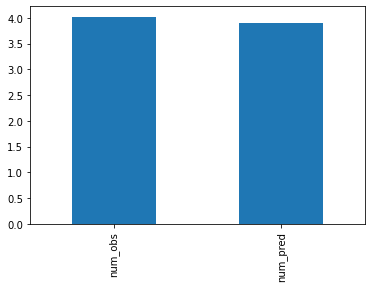

In [22]:
# mean number of injuries per patient
print(match_results[['num_obs','num_pred']].mean())
match_results[['num_obs','num_pred']].mean().plot.bar()

In [23]:
# ISS results
print("ISS equal:", match_results.iss_equal.mean())
print("ISS >=16 equal:", match_results.iss_16_equal.mean())

ISS equal: 0.6901
ISS >=16 equal: 0.9073


In [24]:
iss_16_mismatch = match_results[match_results.iss_16_equal==0]
print("ISS>=16 underpredicted:", len(iss_16_mismatch[iss_16_mismatch.iss_obs>iss_16_mismatch.iss_pred])/len(iss_16_mismatch))

ISS>=16 underpredicted: 0.7540453074433657


iss_obs     10.431644
iss_pred     9.215377
dtype: float64


<AxesSubplot:>

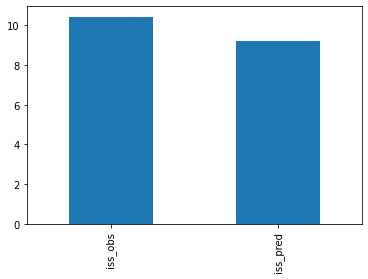

In [25]:
# mean ISS
print(match_results[['iss_obs','iss_pred']].mean())
match_results[['iss_obs','iss_pred']].mean().plot.bar()

In [26]:
# MAIS results
print("MAIS equal:", match_results.mais_equal.mean())
print("MAIS >=3 equal:", match_results.mais_3_equal.mean())

MAIS equal: 0.7594
MAIS >=3 equal: 0.9001


In [27]:
mais_3_mismatch = match_results[match_results.mais_3_equal==0]
print("MAIS>=3 underpredicted:", len(mais_3_mismatch[mais_3_mismatch.mais_obs>mais_3_mismatch.mais_pred])/len(mais_3_mismatch))

MAIS>=3 underpredicted: 0.6896896896896897


mais_obs     2.7448
mais_pred    2.6037
dtype: float64


<AxesSubplot:>

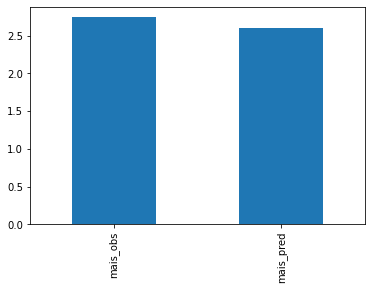

In [28]:
# mean MAIS
print(match_results[['mais_obs','mais_pred']].mean())
match_results[['mais_obs','mais_pred']].mean().plot.bar()

In [29]:
# total codes observed
num_obs = sum(match_results.num_obs)

# match categories
match_cat = pd.DataFrame({'exact':[sum(match_results.exact)/num_obs], \
                          'same_reg_same_sev':[sum(match_results.same_reg_same_sev)/num_obs], \
                          'same_reg_diff_sev':[sum(match_results.same_reg_diff_sev)/num_obs], \
                          'diff_reg_same_sev':[sum(match_results.diff_reg_same_sev)/num_obs], \
                          'diff_reg_diff_sev':[sum(match_results.diff_reg_diff_sev)/num_obs], \
                          'unmatch_obs':[sum(match_results.unmatched_obs)/num_obs], \
                          'unmatch_pred':[sum(match_results.unmatched_pred)/num_obs]})

match_cat

,exact,same_reg_same_sev,same_reg_diff_sev,diff_reg_same_sev,diff_reg_diff_sev,unmatch_obs,unmatch_pred
0,0.541712,0.261616,0.113372,0.023207,0.00883,0.051413,0.020073


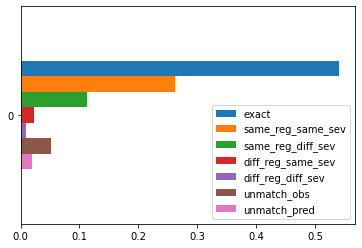

In [30]:
match_cat.plot.barh().invert_yaxis()

(0.0, 0.75)

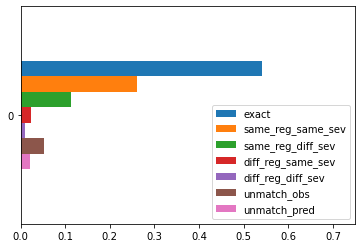

In [31]:
ax = match_cat.plot.barh()
ax.invert_yaxis()
ax.set_xlim(0,0.75)

<AxesSubplot:>

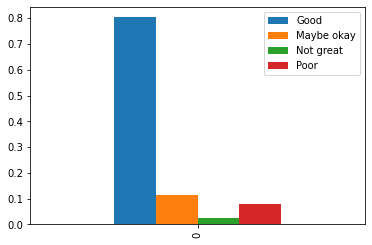

In [32]:
# total codes observed
num_obs = sum(match_results.num_obs)

# match categories
match_cat = pd.DataFrame({'Good':[(sum(match_results.exact) + sum(match_results.same_reg_same_sev))/num_obs], \
                          'Maybe okay':[sum(match_results.same_reg_diff_sev)/num_obs], \
                          'Not great':[sum(match_results.diff_reg_same_sev)/num_obs], \
                          'Poor':[(sum(match_results.unmatched))/num_obs]})

match_cat.plot.bar()

In [33]:
# number of unknown codes
num_unk = len(ais_pred[ais_pred.AIS05CODE.fillna('0').str.contains('<unk>')])
print("Number unknown:", num_unk)
print("Percent unknown", num_unk/len(ais_pred))

Number unknown: 3
Percent unknown 0.0003


In [34]:
unk_idx = ais_pred[ais_pred.AIS05CODE.fillna('0').str.contains('<unk>')].index

test_res.iloc[unk_idx][['ICD9CODE']] \
    .join(ais_obs.iloc[unk_idx].rename(columns={'AIS05CODE':'AIS05CODE_obs'})) \
    .join(ais_pred.iloc[unk_idx].rename(columns={'AIS05CODE':'AIS05CODE_pred'})) \
    .head(5)

,ICD9CODE,AIS05CODE_obs,AIS05CODE_pred
2443,A35 E925.2 P89.52 D957.9,730499,<unk>
6454,A31 E812.2 P31.29 P43.11 P80.51 P81.02 P81.62 ...,640221 650299 710202 810600,<unk> 710202 810602
9429,A60 E910.8 P-1 D854.06 D994.1,161000,100099 <unk>


In [35]:
# number of empty predictions
print("Empty prediction set:",len(ais_pred[ais_pred.AIS05CODE.isnull()]))
print("Percent empty prediction set:",len(ais_pred[ais_pred.AIS05CODE.isnull()])/len(ais_pred))

Empty prediction set: 1
Percent empty prediction set: 0.0001


## Evaluate AAAM map

In [23]:
%%time
sample_res = test_res.head(10000)

# loop through all results
for i in range(0,len(sample_res)):

    # match up lists of AIS codes
    matches = match_ais(sample_res.AIS_obs[i], sample_res.AIS_map[i])
    
    # check if first iteration
    if i==0:
        # create dataframe for results
        match_results_map = match_stats(matches, mapped_codes=False)
        
    else:
        # append results to dataframe
        match_results_map = match_results_map.append(match_stats(matches, mapped_codes=False), ignore_index=True)
        
match_results_map = sample_res.join(match_results_map)

CPU times: user 7min 11s, sys: 260 ms, total: 7min 11s
Wall time: 7min 12s


num_obs     4.0204
num_pred    2.9321
dtype: float64


<AxesSubplot:>

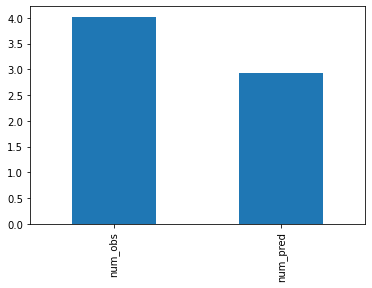

In [24]:
# mean number of injuries per patient
print(match_results_map[['num_obs','num_pred']].mean())
match_results_map[['num_obs','num_pred']].mean().plot.bar()

In [25]:
# ISS results
print("ISS equal:", match_results_map.iss_equal.mean())
print("ISS >=16 equal:", match_results_map.iss_16_equal.mean())

ISS equal: 0.1401
ISS >=16 equal: 0.7444


In [26]:
iss_16_mismatch_map = match_results_map[match_results_map.iss_16_equal==0]
print("ISS>=16 underpredicted:", len(iss_16_mismatch_map[iss_16_mismatch_map.iss_obs>iss_16_mismatch_map.iss_pred])/len(iss_16_mismatch_map))

ISS>=16 underpredicted: 0.7570422535211268


iss_obs     10.431644
iss_pred     6.818500
dtype: float64


<AxesSubplot:>

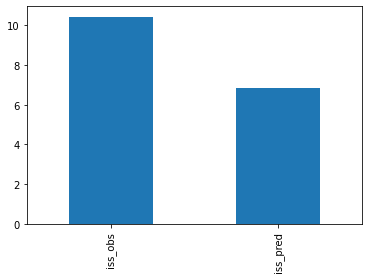

In [27]:
# mean ISS
print(match_results_map[['iss_obs','iss_pred']].mean())
match_results_map[['iss_obs','iss_pred']].mean().plot.bar()

In [28]:
# MAIS results
print("MAIS equal:", match_results_map.mais_equal.mean())
print("MAIS >=3 equal:", match_results_map.mais_3_equal.mean())

MAIS equal: 0.3032
MAIS >=3 equal: 0.494


In [29]:
mais_3_mismatch_map = match_results_map[match_results_map.mais_3_equal==0]
print("MAIS>=3 underpredicted:", len(mais_3_mismatch_map[mais_3_mismatch_map.mais_obs>mais_3_mismatch_map.mais_pred])/len(mais_3_mismatch_map))

MAIS>=3 underpredicted: 0.5938735177865613


mais_obs     2.7448
mais_pred    2.4237
dtype: float64


<AxesSubplot:>

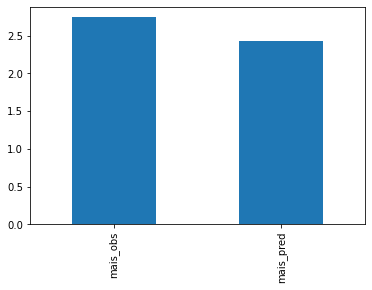

In [30]:
# mean MAIS
print(match_results_map[['mais_obs','mais_pred']].mean())
match_results_map[['mais_obs','mais_pred']].mean().plot.bar()

In [31]:
# total codes observed
num_obs = sum(match_results_map.num_obs)

# match categories
match_cat_map = pd.DataFrame({'exact':[sum(match_results_map.exact)/num_obs], \
                          'same_reg_same_sev':[sum(match_results_map.same_reg_same_sev)/num_obs], \
                          'same_reg_diff_sev':[sum(match_results_map.same_reg_diff_sev)/num_obs], \
                          'diff_reg_same_sev':[sum(match_results_map.diff_reg_same_sev)/num_obs], \
                          'diff_reg_diff_sev':[sum(match_results_map.diff_reg_diff_sev)/num_obs], \
                          'unmatch_obs':[sum(match_results_map.unmatched_obs)/num_obs], \
                          'unmatch_pred':[sum(match_results_map.unmatched_pred)/num_obs]})

match_cat_map

,exact,same_reg_same_sev,same_reg_diff_sev,diff_reg_same_sev,diff_reg_diff_sev,unmatch_obs,unmatch_pred
0,0.002935,0.096184,0.077281,0.191971,0.12653,0.516789,0.246095


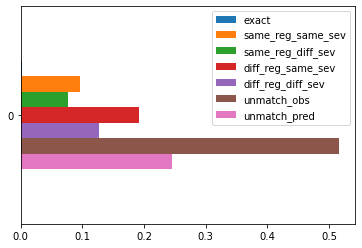

In [32]:
match_cat_map.plot.barh().invert_yaxis()

<AxesSubplot:>

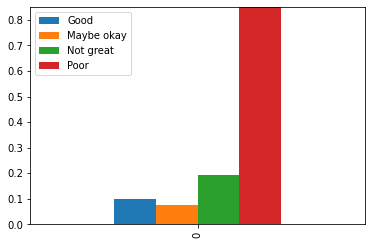

In [33]:
# total codes observed
num_obs = sum(match_results_map.num_obs)

# match categories
match_cat_map = pd.DataFrame({'Good':[(sum(match_results_map.exact) + sum(match_results_map.same_reg_same_sev))/num_obs], \
                          'Maybe okay':[sum(match_results_map.same_reg_diff_sev)/num_obs], \
                          'Not great':[sum(match_results_map.diff_reg_same_sev)/num_obs], \
                          'Poor':[(sum(match_results_map.unmatched))/num_obs]})

match_cat_map.plot.bar(ylim=(0,.85))